# Sentiment Analysis on selected migration related articles over time (2015-2018)

* The goal of this analysis is to find out which was the evolution of the sentimental projection of the migration topic by the media, in this case, Der Spiegel.
* Due to the lack of labeled training datasets in german and, therefore, lack of robusst pre-trained sentiment models we will translate selected articles to english through the Google Translate API and apply existing models to the result.
* We want to use a recurrent neural network model (LSTM) since we want to consider the history on the sentiment over the words/sentences for each article (i.e. if there is a negation estatment it will be consider for all the sucessive words).
* In this case we will use a LSTM [model](https://github.com/openai/generating-reviews-discovering-sentiment) with 4,096 units we trained on the Amazon product review dataset introduced in McAuley et al. (2015) [1]. The dataset in de-duplicated form contains over 82 million product reviews from May 1996 to July 2014 amounting to over 38 billion training bytes. Training took one month across four NVIDIA Pascal GPUs, with our model processing 12,500 characters per second.
* The output of the model is the 4,096 hidden units from last layer. As reported in the paper for the binary version of the Stanford Sentiment Treebank (SST), the unit "2,388" contains the sentiment information (see distribution of values for positive and negative labels in the picture below). Therefore, we will just analyze the content of this one and apply over the results the binary classifier model as described [here](https://github.com/openai/generating-reviews-discovering-sentiment/blob/master/sst_binary_demo.py).
* In order to achieve our goal in considerable computational time (sentiment prediction of text with 642 words took half an hour in a 4 cores MacBook Air) and reduce the amount of request to Google API we will
    * Discard articles with more than 700 words
    * Select randomly 30 articles per quarter (calculated time in 4CPUs 15GB 1.8 days)
    * Discard n% initial and final sentences for each article

[[1]](https://arxiv.org/pdf/1704.01444.pdf) Radford, Alec, Jozefowicz, Rafal, and Sutskever, Ilya. Learning to Generate Reviews and Discovering Sentiment. 2017

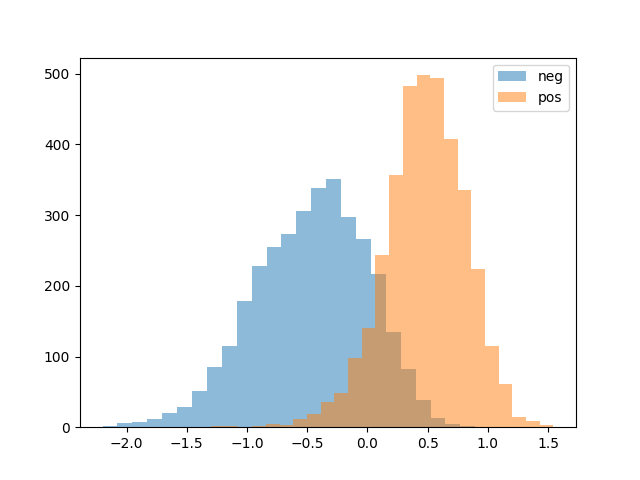

In [3]:
from IPython.display import Image
Image("../../img/sst_binary_sentiment_unit_vis.png")

We can expect that only texts with a sentiment score out of the range [-1,1] could be labeled as negative or positive respectively. Otherwise, the general sentiment should have the neutral label.

In [273]:
import nltk
import re
import sys
import os
import pickle
import requests
import datetime
import argparse
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('subjectivity')
from nltk.sentiment.util import demo_vader_instance, demo_sent_subjectivity
sys.path.append("../..")
from src.helpers import assign_quarter_labels, get_quarter_boundaries
from src.translator import extract_n_articles_and_translate, google_translator
sys.path.append("../../../generating-reviews-discovering-sentiment/")
from encoder import Model
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/celsadiaz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package subjectivity to
[nltk_data]     /Users/celsadiaz/nltk_data...
[nltk_data]   Package subjectivity is already up-to-date!
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [272]:
from IPython import display
from IPython.core.magic import register_cell_magic, Magics, magics_class, cell_magic
import jinja2

# Code imported from https://gist.github.com/bj0/5343292 for html representation of text sentiment 
# within jupyter notebook

@magics_class
class JinjaMagics(Magics):
    '''Magics class containing the jinja2 magic and state'''
    
    def __init__(self, shell):
        super(JinjaMagics, self).__init__(shell)
        
        # create a jinja2 environment to use for rendering
        # this can be modified for desired effects (ie: using different variable syntax)
        self.env = jinja2.Environment(loader=jinja2.FileSystemLoader('.'))
        
        # possible output types
        self.display_functions = dict(html=display.HTML, 
                                      latex=display.Latex,
                                      json=display.JSON,
                                      pretty=display.Pretty,
                                      display=display.display)

    
    @cell_magic
    def jinja(self, line, cell):
        '''
        jinja2 cell magic function.  Contents of cell are rendered by jinja2, and 
        the line can be used to specify output type.

        ie: "%%jinja html" will return the rendered cell wrapped in an HTML object.
        '''
        f = self.display_functions.get(line.lower().strip(), display.display)
        
        tmp = self.env.from_string(cell)
        rend = tmp.render(dict((k,v) for (k,v) in self.shell.user_ns.items() 
                                        if not k.startswith('_') and k not in self.shell.user_ns_hidden))
        
        return f(rend)
        
    
ip = get_ipython()
ip.register_magics(JinjaMagics)

In [2]:
# Use the German stopwords.
stpwrds = stopwords.words("german")

# We added some additional characters to avoid.
characters = [',', '.', '(', ')', '!', ';', '-', ':', '...', '"',
                "''", "``", '~http', '?', '@', '#', '/', "'",
                '&', '--', '[', ']', '=', '||', '+', '_', '..',
                '%', '|', '~', 'http',"\n","—","•","“","„","–",
                "في","שראל","россии","не","минобороны","и","в",
                "את", "$",">","*"]

# Selection of articles parameters
# number of top articles with higher frequencies on key words for selecting the final ones
n_pre_selected = 75
n_articles = 30
language = 'en'

In [4]:
# Load selected articles about migration
articles = pd.read_csv("../../data/migration_articles.csv")
articles.date = articles['date'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d"))

In [5]:
articles[(articles['date'].dt.year == 2015) & (articles['quarter'] == 'q11_18')]

,text,date,meta_description,time_line,quarter,is_summary,text_length,article_id,freq


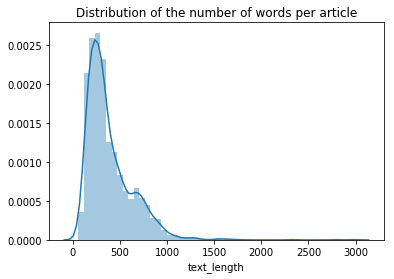

In [5]:
# Explore the distribution of number of words per article
articles['text_length'] = articles['text'].apply(lambda x: len(x.split(" ")))
_=sns.distplot(articles['text_length'])
_=plt.title("Distribution of the number of words per article")

It looks like there are two main types of articles, short ones of around 300 words and longer ones of around 700. We will get focused on the short ones in the sentiment analysis for performance reasons fixing the length threshold at 700 words.

In [6]:
articles_short = articles[articles["text_length"] < 700].reset_index(drop=True)

In [7]:
articles_short.head()

,text,date,meta_description,time_line,quarter,is_summary,text_length,article_id,freq
0,Die Offensive von Baschar al-Assad im Süden Sy...,2018-07-09,Syrien plant einen Angriff auf die Golanhöhen....,32080,q11_18,0,559,32080,0.011696
1,In der Debatte um die Asylpolitik in Deutschla...,2018-07-09,Entwicklungshilfeminister Gerd Müller (CSU) ha...,32071,q11_18,0,249,32071,0.012903
2,Wenige Tage vor dem EU-Ministertreffen in Inns...,2018-07-08,Italien weist bereits Schiffe von Hilfsorganis...,32062,q11_18,0,314,32062,0.018779
3,Der Vorwurf wiegt schwer: Niedersachsens Innen...,2018-07-08,Niedersachsens Innenminister Pistorius soll ei...,32056,q11_18,0,265,32056,0.013072
4,"Liebe Abonnentin, lieber Abonnent,\n\nin unser...",2018-07-07,Deutschlands führende Nachrichtenseite. Alles ...,32033,q11_18,0,513,32033,0.010033


In [64]:
print(f"There are {len(articles_short)} articles about migration with less than 700 words.")

There are 2388 articles about migration with less than 700 words.


### Select a set of 30 articles per quarter

In [120]:
#articles_selected_ = extract_n_articles_and_translate(articles_short, n_pre_selected, n_articles, language)

In [71]:
# Goole translate API can not translate all the artcles at once and therefore we need to run it several times
if len(articles_selected_[articles_selected_["text_en"].isnull()]) > 0:
    # translate articles that for some reason were not translated
    non_translated = articles_selected_[articles_selected_["text_en"].isnull()]
    non_translated["text_en"] = non_translated["text"].apply(lambda x: google_translator(x, language))
    
    translated = non_translated[non_translated['text_en'] != '']
    
    # update translations
    articles_to_replace = translated.index.tolist()
    for art in articles_to_replace:
        articles_selected_.loc[art, "text_en"] =  translated.loc[art, "text_en"]

In [72]:
# ensure that all texts are translated
articles_selected_[articles_selected_["text_en"].isnull()]

,text,date,meta_description,time_line,quarter,is_summary,text_length,article_id,freq,text_en


In [90]:
articles_selected_.to_csv("../../data/330_selected_art_translated.csv", index=False, encoding='utf-8')

#### Extract articles IDs of the analyzed articles to match sentiment to date

In [50]:
articles_selected = pd.read_csv("../../data/330_selected_art_translated.csv")
articles_selected.date = articles_selected['date'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d"))

In [55]:
articles_sel_correct = articles_selected.loc[:,('date','quarter',
                         'time_line','text_en')].rename(columns={'quarter':'wrong_q'}).merge(articles.loc[:,('date',
                                         'quarter','time_line')],
                                            left_on='time_line', right_on='time_line')

In [56]:
articles_sel_correct[(articles_sel_correct['date_x'].dt.year == 2015) & (articles_sel_correct['quarter'] == 'q11_18')]

,date_x,wrong_q,time_line,text_en,date_y,quarter


In [57]:
order_articles_asc = articles_sel_correct.sort_values(by='date_x').index.tolist()

In [9]:
se_order_art_to_quarter = articles_sel_correct.sort_values(by='date_x').quarter

In [10]:
len(se_order_art_to_quarter)

330

### Run sentiment analysis of selected articles in Google Cloud

#### Test performance with first article

Performance
- macbook air: 4cores 4GB 
    - article with 319 words/2368 characters 1274.9s -> 21.2’
    - total = 30 articles/quarter x 11 quarters x 21.2' -> 4.8 days
- GC: 4CPUs 15GB
    - article with 319/2368 characters 479.9 -> 7.9’
    - total = 30 articles/quarter x 11 quarters x 7.9' -> 1.8 days

### Check sentiment

In [11]:
file_100 = open("../../data/sentiment_analysis_scores_checkpoint.pkl",'rb')
file_100_on = open("../../data/sentiment_analysis_scores.pkl",'rb')
sentiment_100 = pickle.load(file_100)
sentiment_100_on = pickle.load(file_100_on)

In [12]:
sentiment = sentiment_100[:100] + sentiment_100_on

In [13]:
len(sentiment)

330

###### Sentiment per article evolution

In [14]:
# shape results array with sentiment per article to be readable
sentiment_clean = pd.DataFrame(sentiment).T.dropna().T
rec = [{'a_idx': ia, 'sentiment': sent} for ia, a in enumerate(sentiment)  for sent in a]
df = pd.DataFrame.from_records(rec)

# order articles by date (2015 -> 2018)
tmp_ordered = []
for i, art in enumerate(order_articles_asc):
    sel = df[df['a_idx']==art]
    sel['index'] = i
    tmp_ordered.append(sel)
tmp_ordered = pd.concat(tmp_ordered).reset_index(drop=True)

In [198]:
len(tmp_ordered['index'].unique())#.quarter.tolist()

330

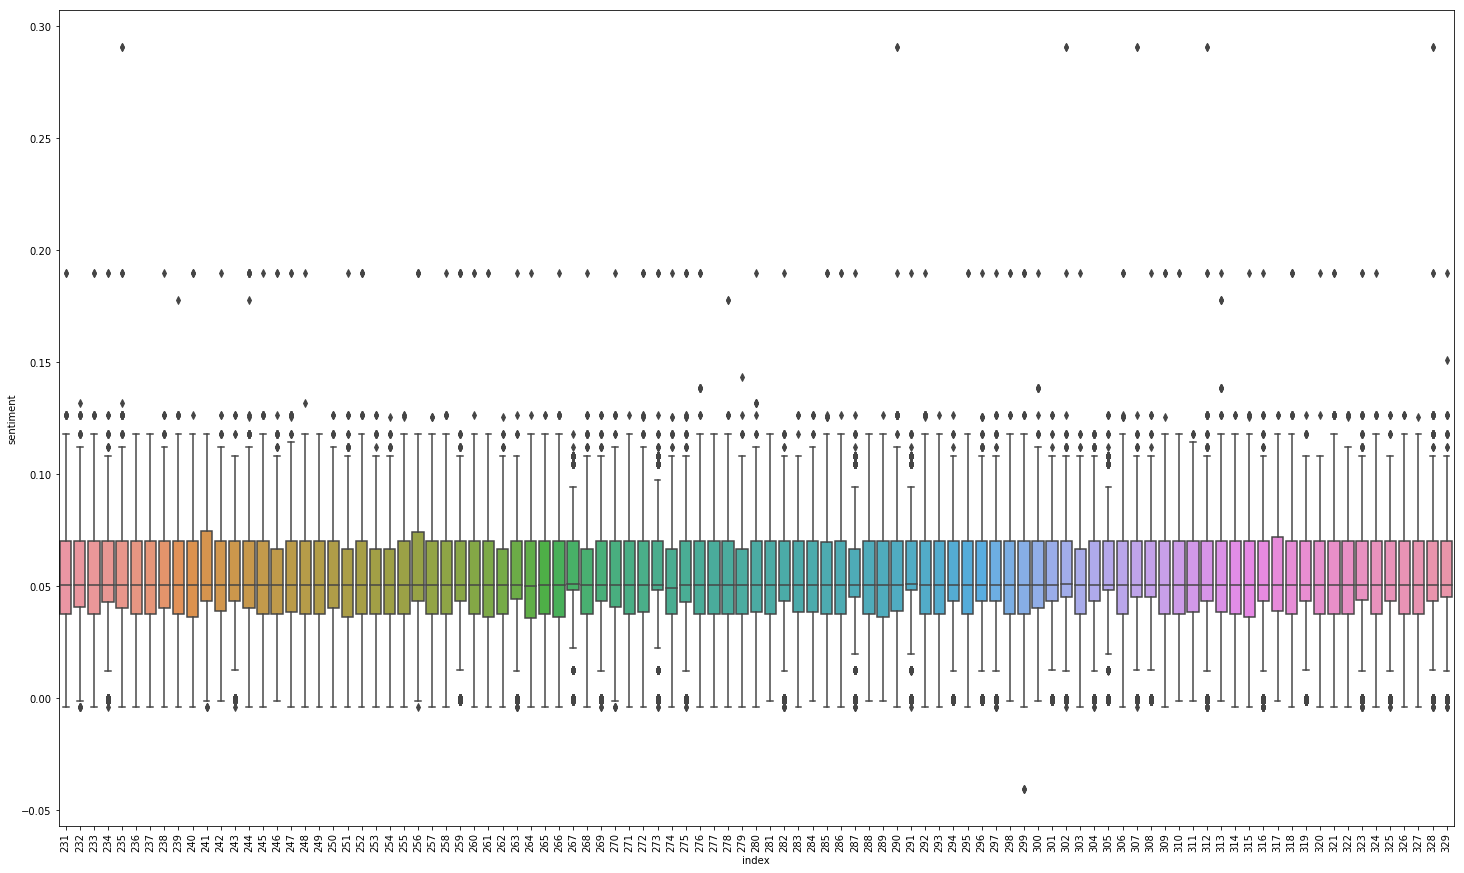

In [203]:
_=plt.figure(figsize=(25, 15))
_=sns.boxplot(data=tmp_ordered[tmp_ordered['index']>230], x='index', y='sentiment')
_=plt.xticks(rotation=90)

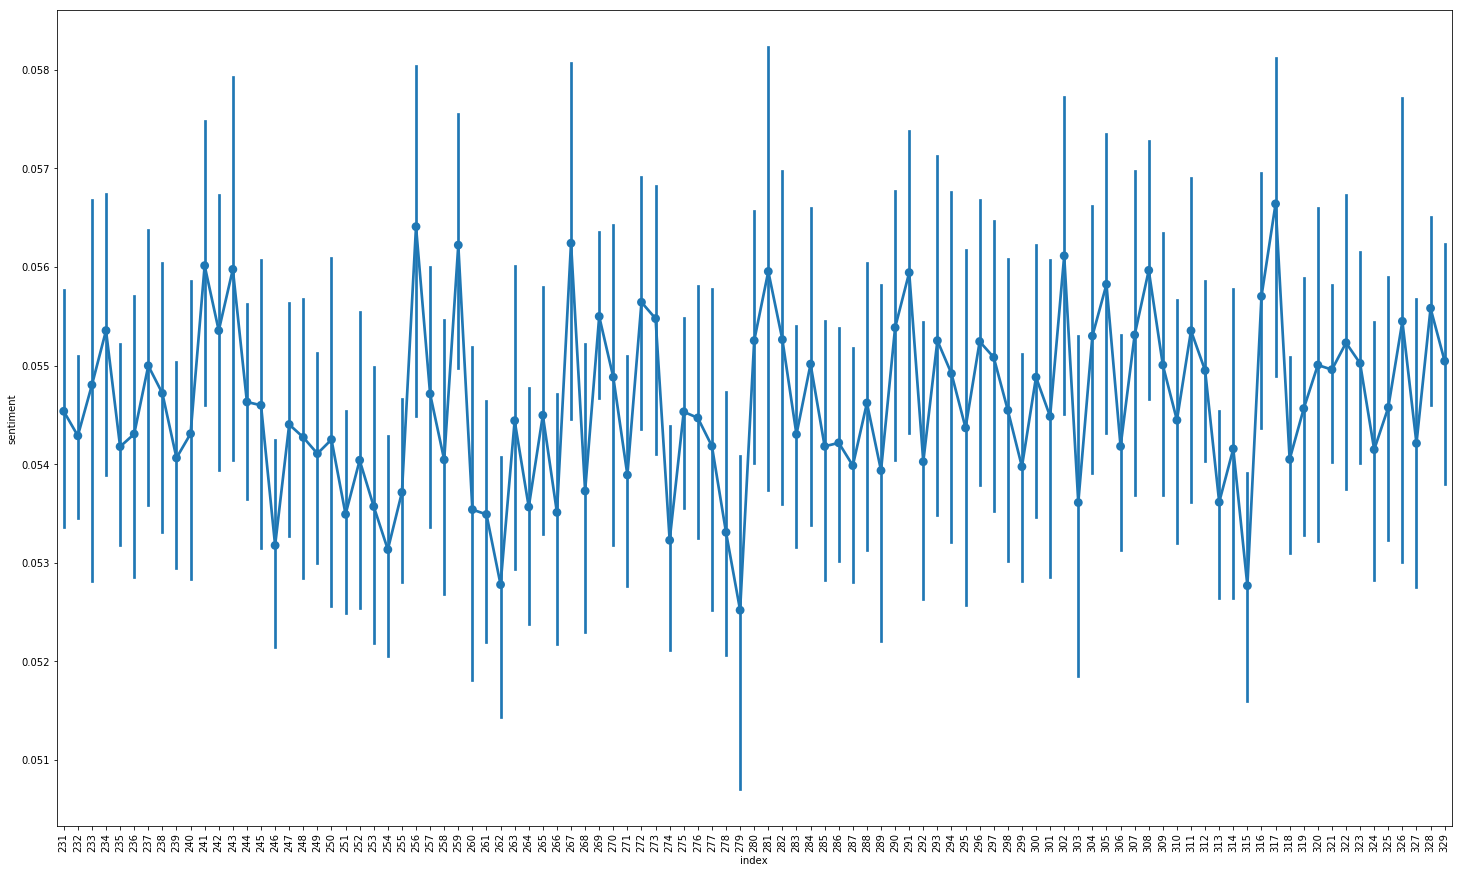

In [204]:
_=plt.figure(figsize=(25, 15))
_=sns.pointplot(data=tmp_ordered[tmp_ordered['index']>230], x='index', y='sentiment')
_=plt.xticks(rotation=90)

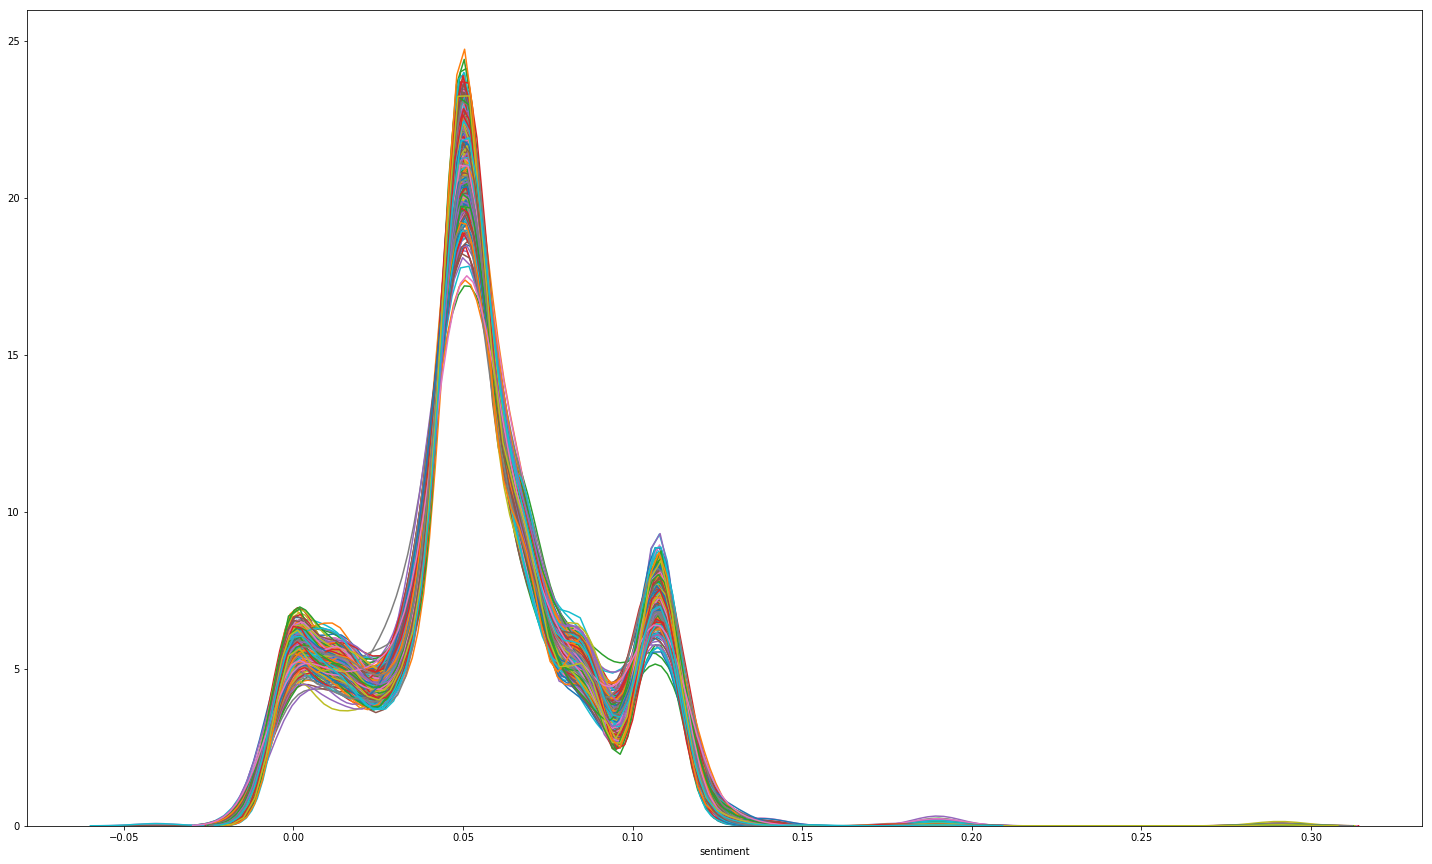

In [44]:
plt.figure(figsize=(25, 15))
for i in tmp_ordered.a_idx.unique().tolist():#[::5]:
    sns.distplot(tmp_ordered[tmp_ordered['a_idx']==i]['sentiment'], hist=False, rug=False)

###### Sentiment per quarter

In [230]:
# map quarters to idx_a
tmp_ordered['quarter'] = tmp_ordered['a_idx'].map(se_order_art_to_quarter)

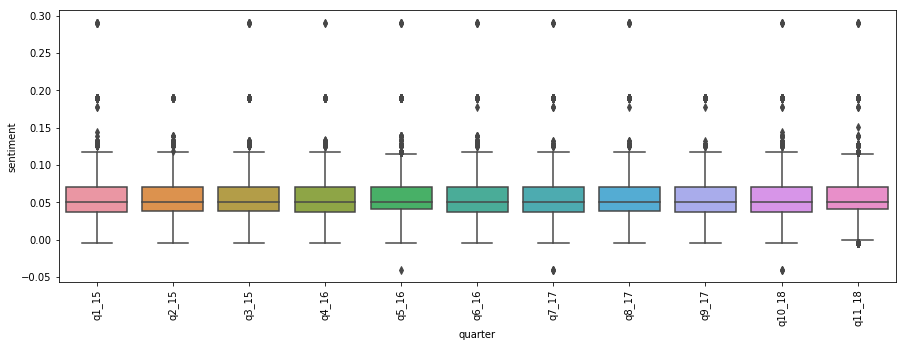

In [252]:
_=plt.figure(figsize=(15, 5))
_=sns.boxplot(data=tmp_ordered, x='quarter', y='sentiment')
_=plt.xticks(rotation=90)

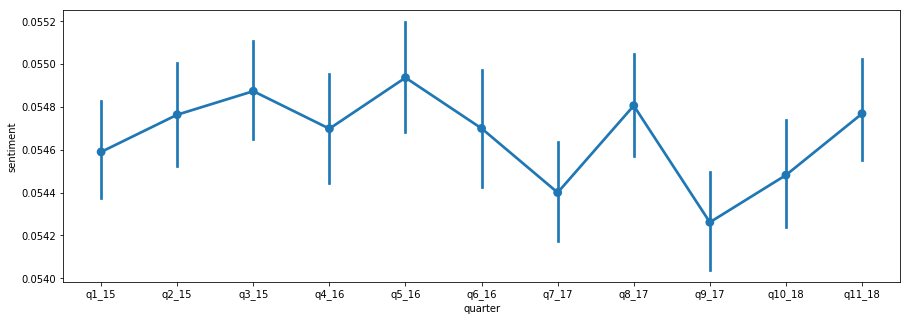

In [253]:
_=plt.figure(figsize=(15, 5))
_=sns.pointplot(data=tmp_ordered, x='quarter', y='sentiment')

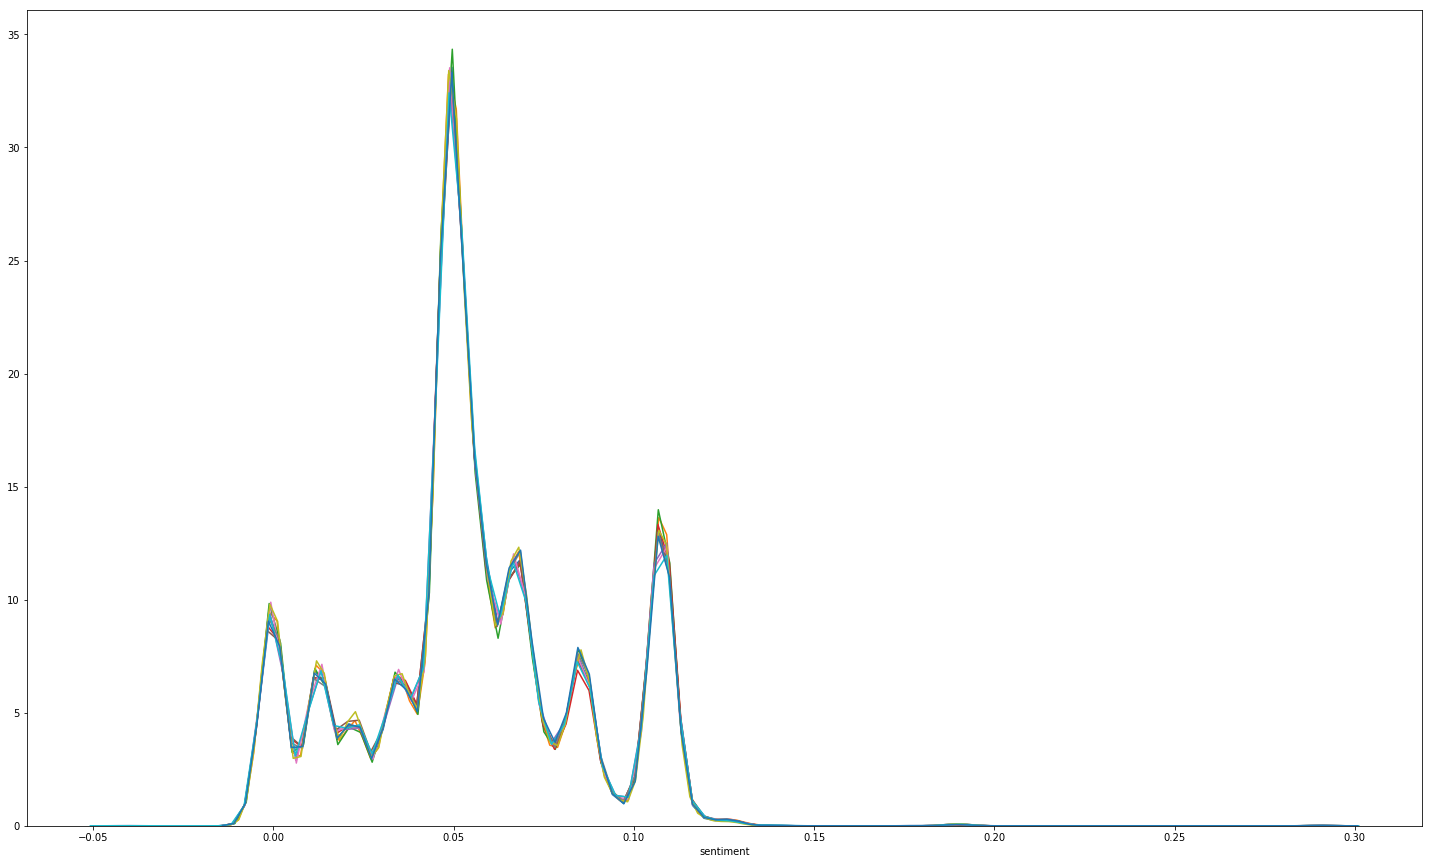

In [36]:
plt.figure(figsize=(25, 15))
for i in tmp_ordered.quarter.unique().tolist():
    sns.distplot(tmp_ordered[tmp_ordered['quarter']==i]['sentiment'], hist=False, rug=False)

###### Build color mapper -> Once color per pick

In [263]:
#colors = ['#D62C00','#D64C00','#D66A00','#D68500','#D69E00','#D6B600','#BAE900','#67E900']#,'#00F766']
#boundaries = [0.4,0.1,0.075,0.06,0.04,0.035,0.02,0.01,-0.1]
colors = ['#D62C00','#D68500','#67E900']
boundaries = [1,0.5,-0.5,-1]

In [264]:
color_mapper = []
for i, col in enumerate(colors):
    color = {}
    color['color'] = col
    color['max'] = boundaries[i]
    color['min'] = boundaries[i+1]
    color_mapper.append(color)
color_mapper = pd.DataFrame.from_records(color_mapper)

In [265]:
color_mapper.head(2)

,color,max,min
0,#D62C00,1.0,0.5
1,#D68500,0.5,-0.5


### Visualize sentiment per article tool

In [266]:
def extract_color(value):
    series = color_mapper[(color_mapper['min'] < value) & (color_mapper['max'] > value)]
    return series['color'].values[0]

def build_sequence_visualizer(text, sentiment, color_mapper):
    characters = list(text)
    values = pd.DataFrame({'char': characters, 'sentiment': sentiment})
    values['color'] = values['sentiment'].apply(lambda x: extract_color(x))
    return values

In [267]:
# one example of an article of the "most positive" quarter
pos_art = articles_sel_correct.loc[299]
pos_sent = tmp_ordered[tmp_ordered['a_idx']==299]['sentiment'].tolist()

# one example of an article of the "most negative" quarter
neg_art = articles_sel_correct[articles_sel_correct['quarter']=='q9_17'].loc[314]
neg_sent = tmp_ordered[tmp_ordered['a_idx']==314]['sentiment'].tolist()

In [268]:
rec_pos = build_sequence_visualizer(pos_art['text_en'], pos_sent, 
                                    color_mapper).loc[:,('char','color')].to_dict('records')
rec_neg = build_sequence_visualizer(neg_art['text_en'], neg_sent, 
                                    color_mapper).loc[:,('char','color')].to_dict('records')

In [1]:
#%%jinja html
#<html>
#<body>
#{% for r in rec_pos %}<span style="background-color: {{ r.color }} ;">{{ r.char }}</span>{% endfor %} 
#</body>
#</html>

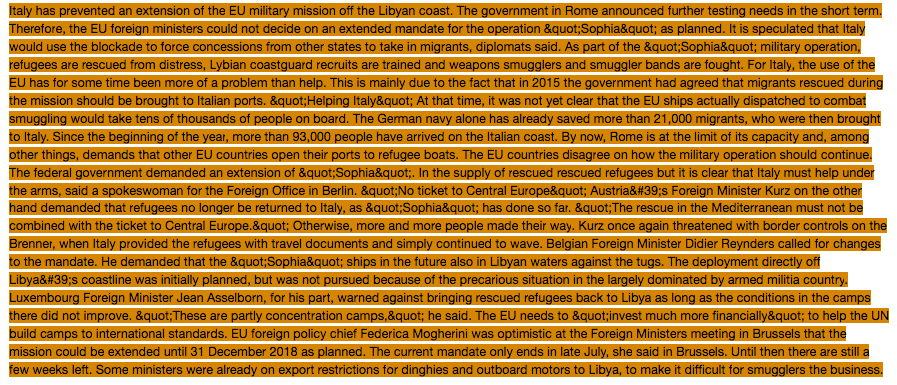

In [4]:
Image("../../img/sentiment_correct.png")

### Conclusions

* The LSTM character based model for sentiment feature extraction showed that migration-related articles extracted from Der Spiegel have been neutral during the last 4 years. Good news for journalistic objectivity in Der Spiegel, mainly regarding this sensible topic.

* When analyzing the distribution of the sentiment over all articles, we see that all of them follow the same distribution with 8 peaks (see distribution aggregated by quarters). The differences on the sentiment for each peak is not relevant.

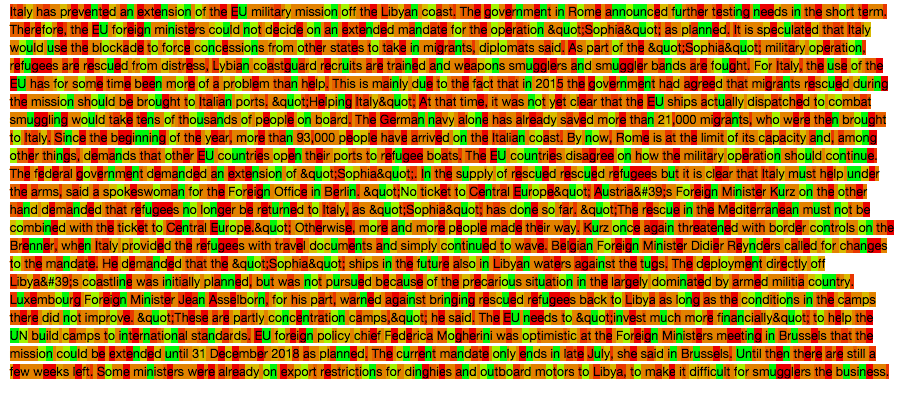

In [262]:
Image("../../img/explore_peak_sentiment.png")

* Comparison of the distribution of quartiles for sentiment values per article over the time showed no relevant differences. Only when comparing the mean values of the sentiment per article aggregated by quarter we see two, almost insignificant, drops around US and DE elections. We can conclude that the only significant difference is on the mean values of the third quarter of 2015 and second quarter of 2016 (as the most positive) and the last quarter of 2017 (as the most negative). Despite of the weakness of the difference between these mean values, the fact is that it is in the third quarter of 2015 and second quarter of 2016 when european citizens and even media started a solidarity wave after the anti-human rights policy of european governments, mainly in 2016. On the other hand, ir is at the end of 2017, with the german elections, when right-populism achieves its strongest support.
* What we see in [Sutskever et al., 2017](https://arxiv.org/pdf/1704.01444.pdf) is that words such as "great", "quite", "mistery", "waste", "tiresome" are the type of words having an impact on the change of the sentiment of the sentences. The model was trained with 82 million Amazon product reviews that mainly contain these kind of words. However, in the migration context, besides of these words, that are not that much present, there are topic specific words with negative and positive connotation depending on the context (i.e. "Populisten", "Abschiebung", "Deutschen", "Demokratie", "Kriminalität", "Videoüberwachung"). The problem with these positive/negetive classification of words by topic is that the classification is pretty subjective, readers of "Das Bild" would consider positive an article that readers of "Taz" will consider as negative.